In [1]:
import sys, os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

from RFSoC_Daq import RFSoC_Daq
from Biquad import Biquad
from SimBiquad import SimBiquad
from Biquad_Daq import Biquad_Daq
from Waveforms.Waveform import Waveform

In [2]:
daq = Biquad_Daq()
sim = SimBiquad()

DEBUG:RFSoC_Daq:Asked to load overlay at /home/xilinx/python/zcumts.py
DEBUG:RFSoC_Daq:Adding directory /home/xilinx/python to module search path
DEBUG:RFSoC_Daq:Changing directory to /home/xilinx/python
DEBUG:RFSoC_Daq:Going to try to import zcumts
DEBUG:RFSoC_Daq:Found Overlay class Overlay from module pynq.overlay
DEBUG:RFSoC_Daq:Found RFSoC overlay zcuMTS


Turning on SYNC
Turning off SYNC


DEBUG:RFSoC_Daq:Created RFSoC device
DEBUG:RFSoC_Daq:Restoring original module search path
DEBUG:RFSoC_Daq:Going back to original directory /home/xilinx/rfsoc-pydaq/Biquad/Notebooks/tests


In [3]:
import pynq

import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual, HBox
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [4]:
def update_plot(A, B, P, theta):
    
    global daq_output
    global sim_output
    global diff_output
    
    Xn = [0, 0, 0, 0, 0, 0, 0]
    Cross = [1, 0, 0, 0]
    C = [0 ,0, 0, 0]
    
    daq.update_params(A, B, P, theta*np.pi)
    
    # daq.set_Xn(*Xn)
    # daq.set_poleFIR(*Cross)
    # daq.set_poleIIR(*C)
    
    daq.quantise_coeffs()
    
    daq.run_zeroFIR()
    daq.run_poleFIR()
    daq.run_poleIIR()
    
    daq.update_waveforms()
    
    sim.update_params(A, B, P, theta*np.pi)
    
    sim.data = daq.adcBuffer[0] >> 4
    
    # sim.set_Xn(*Xn)
    # sim.set_poleFIR(*Cross)
    # sim.set_poleIIR(*C)
    
    sim.quantise_coeffs()

    sim.run_zeroFIR(quant=True)
    sim.run_poleFIR(quant=True)
    sim.run_poleIIR(quant=False)
    
    daq_output = daq.extract_biquad()
    sim_output = sim.extract_biquad(quant=True)
    diff_output = Waveform(daq_output.waveform - sim_output.waveform)
    
    fig, (axB,axS,axR) = plt.subplots(3, 1, figsize=(25, 15))
        
    daq_output.plotWaveform(axB, title="Biquaded ADC224_T0_CH0")
    
    sim_output.plotWaveform(axS, title="Simulated Biquad")
    
    diff_output.plotWaveform(axR, title="Difference")
    
    plt.show()

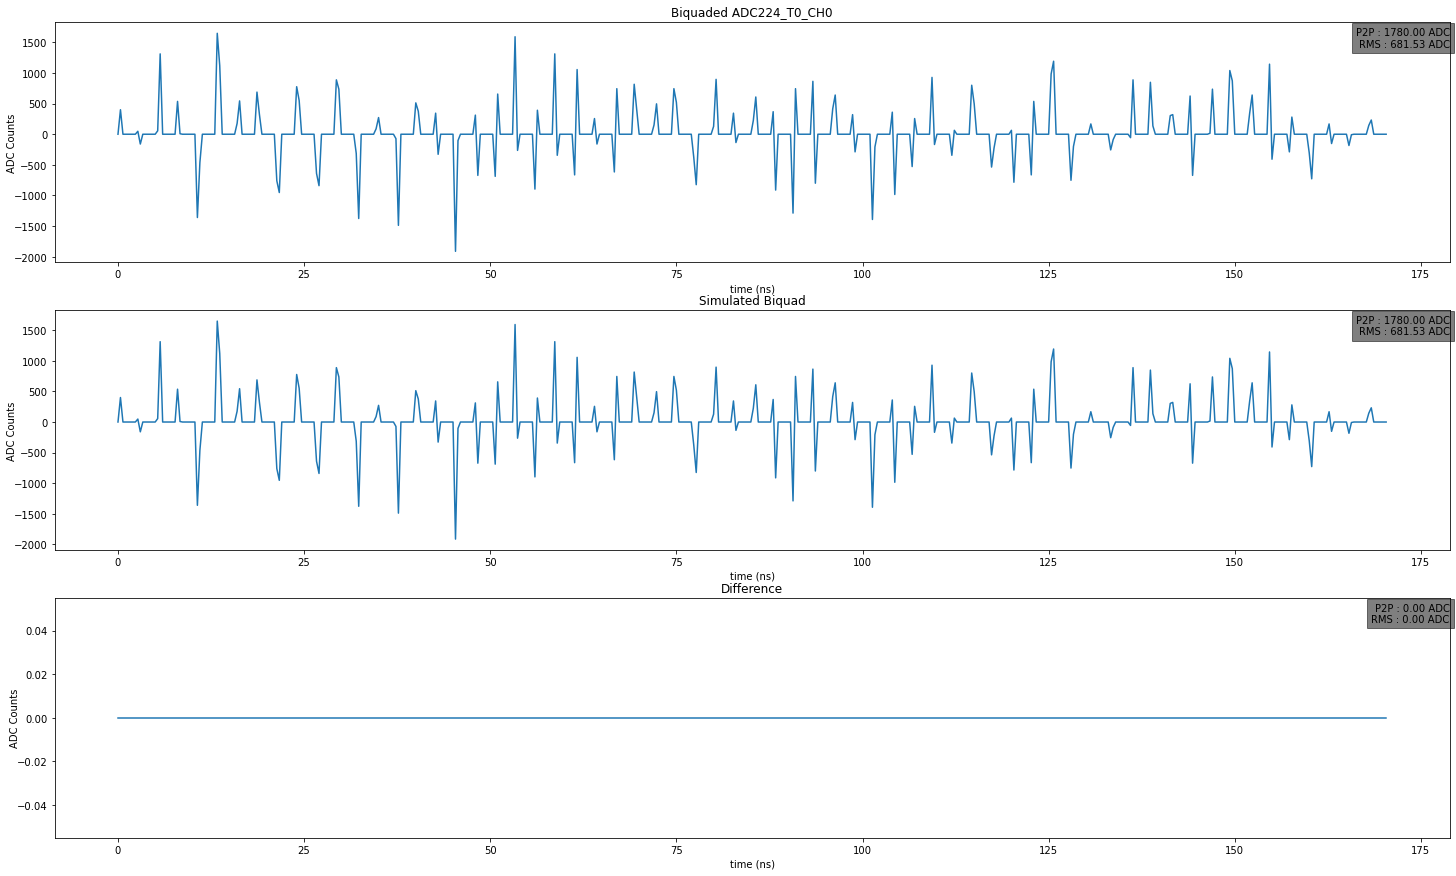

[  0 400   0   0   0   0   0   0]
[  0. 400.   0.   0.   0.   0.   0.   0.]


In [11]:
A = 0#0.9270403427317333
B = -8#-1.3110330255582197
P = 0#0.9241648583794272
theta = 0.7822818617748523

update_plot(A = A, B = B, P = P, theta = theta)
print(daq_output[:8])
print(sim_output[:8])

In [13]:
count = 0
err_one = 0
err_two = 0
big = 0
iterations = 1000

A = -8#0.9270403427317333
B = -8#-1.3110330255582197
P = 0#0.9241648583794272
theta = 0.7822818617748523


daq.update_params(A, B, P, theta)
daq.quantise_coeffs()
sim.update_params(A, B, P, theta)
sim.quantise_coeffs()

daq.run_zeroFIR()
daq.run_poleFIR()
daq.run_poleIIR()

for _ in range(iterations):

    daq.update_waveforms()
    
    sim.data = daq.adcBuffer[0] >> 4
    sim.run_zeroFIR()
    sim.run_poleFIR()
    sim.run_poleIIR()
    
    daq_output = daq.extract_biquad()
    sim_output = sim.extract_biquad()
    diff_output = Waveform(daq_output.waveform - sim_output.waveform)
    
    if diff_output.calc_rms() != 0:
        count+=1
        
        if diff_output.calc_rms()==0.04419417382415922:
            err_one+=1
        if diff_output.calc_rms()==0.0625:
            err_two+=1
        if diff_output.calc_rms()>0.0625:
            big +=1
                
        # print("##############################")
        # print(f"A : {A} | B : {B} | P : {P} | theta {theta}")
        # print(diff_output.calc_rms())
        # print("##############################")

print('')
print(f"Total Error Count : {count}")
print(f"Total Error Percentage : {100*count/iterations}%")

print('')
print(f"1 sample 1 off Count : {err_one}")
print(f"1 sample 1 off Percentage : {100*err_one/iterations}%")

print('')
print(f"1/2 sample 2/1 off Count : {err_two}")
print(f"1/2 sample 2/1 off Percentage : {100*err_two/iterations}%")

print('')
print(f"Effective Error Count : {big}")
print('')
print(f"Effective Error Percentage : {100*big/iterations}%")


Total Error Count : 0
Total Error Percentage : 0.0%

1 sample 1 off Count : 0
1 sample 1 off Percentage : 0.0%

1/2 sample 2/1 off Count : 0
1/2 sample 2/1 off Percentage : 0.0%

Effective Error Count : 0

Effective Error Percentage : 0.0%


In [7]:
# A_slider = widgets.FloatSlider(min=-8, max=7.9, step=0.05, value=1.75, description='A:', continuous_update=False)
# B_slider = widgets.FloatSlider(min=-8, max=7.9, step=0.05, value=2.95, description='B:', continuous_update=False)
# P_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.4, description='P:', continuous_update=False)
# Theta_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.67, description='Theta:', continuous_update=False)

# plot_output = widgets.Output()
    
# def update(change):
#     with plot_output:
#         plot_output.clear_output(wait=True)
#         update_plot(A = A_slider.value, B = B_slider.value, P = P_slider.value, theta = Theta_slider.value)
    
# A_slider.observe(update, names='value')
# B_slider.observe(update, names='value')
# P_slider.observe(update, names='value')
# Theta_slider.observe(update, names='value')

# # Layout
# slider_box = widgets.HBox([A_slider, B_slider, P_slider, Theta_slider])
# ui = widgets.VBox([slider_box, plot_output])

# # Display
# display(ui)

# # Initial plot
# update(None)

In [8]:
# count = 0
# big = 0
# iterations = 100
# for _ in range(iterations):
#     A = (np.random.random()-0.5) * 3
#     B = (np.random.random()-0.5) * 3
#     P = np.random.random() * 0.95
#     theta = np.random.random() * np.pi
    
#     daq.update_params(A, B, P, theta)
#     daq.quantise_coeffs()
    
#     daq.run_zeroFIR()
#     daq.run_poleFIR()
#     daq.run_poleIIR()
    
#     daq.update_waveforms()
    
#     sim.update_params(A, B, P, theta)
#     sim.quantise_coeffs()
#     sim.data = daq.adcBuffer[0] >> 4

#     sim.run_zeroFIR()
#     sim.run_poleFIR()
#     sim.run_poleIIR()
    
#     daq_output = daq.extract_biquad()
#     sim_output = sim.extract_biquad()
#     diff_output = Waveform(daq_output.waveform - sim_output.waveform)
    
#     if diff_output.calc_rms() != 0:
#         count+=1
#         if diff_output.calc_rms()!=0.04419417382415922:
#             big+=1
#         # print("##############################")
#         # print(f"A : {A} | B : {B} | P : {P} | theta {theta}")
#         # print(diff_output.calc_rms())
#         # print("##############################")

# print('')
# print(f"Error Count : {count}")
# print('')
# print(f"Error Percentage : {100*count/iterations}%")


# print('')
# print(f"Actual Error Count : {big}")
# print('')
# print(f"Actual Error Percentage : {100*big/iterations}%")

Test base 375 MHz configuration